# K-means, Gaussian Mixture Model 직접 구현하기

이번 과제에서는 Unsupervised Algorithm 의 대표적인 군집화 알고리즘 두개를 직접 구현해보도록 한다.

먼저 IRIS 데이터를 읽도록 하자 (IRIS데이터에는 레이블 값이 존재하나, 이번 과제에서는 레이블 값을 무시하고, 데이터포인트만 사용한다)

In [1]:
from sklearn import datasets
# import some data to play with
iris = datasets.load_iris()
X = iris.data[:, :2]  # we only take the first two features.

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

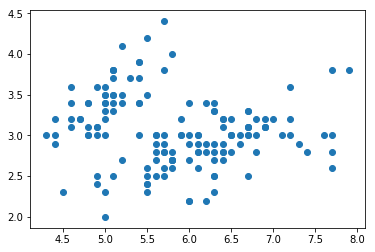

In [3]:
plt.scatter(X[:,0], X[:,1])

을 군집화가 세개 있다고 가정하고, K-means 와 GMM으로 각 좌표가 어느 집단에 속하는지 추측해보도록 하자.

## 1. K-means 를 DataFrame 을 사용하여, 구해보자. 다음의 힌트를 사용하시오.

In [4]:
import pandas as pd
import numpy as np
df = pd.DataFrame({
    'user_id':[1,2,1,3,3,],
    'content_score':[4,1,2,3.5,2],
})

In [5]:
df

,user_id,content_score
0,1,4.0
1,2,1.0
2,1,2.0
3,3,3.5
4,3,2.0


user_id 로 묶어서, 컨텐츠의 평균 점수를 구하는 코드는 아래와 같다.

In [6]:
df.groupby("user_id")["content_score"].mean()

user_id
1    3.00
2    1.00
3    2.75
Name: content_score, dtype: float64

참고로, 위 평균 series 를 처음 데이터프레임에 합치는 방법은 다음과 같다.

In [7]:
df['group_mean'] = df['content_score'].groupby(df['user_id']).transform('mean')
df

,user_id,content_score,group_mean
0,1,4.0,3.00
1,2,1.0,1.00
2,1,2.0,3.00
3,3,3.5,2.75
4,3,2.0,2.75


여기서부터 본인들이 할 것. pandas apply 함수를 찾아볼 것.

### K-means 로 직접 데이터의 군집을 추측하여, 색깔을 입혀 그래프로 그리시오.

In [8]:
predicted_means = np.array([[4,3],[6,4],[8,4]]) # 전체 데이터의 각 끝 점으로 추측

아래 코드를 계속 반복해서 실행해보면 Class가 바뀌는 걸 확인할 수 있습니다.

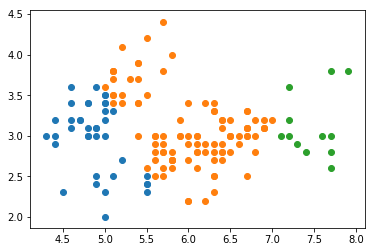

In [9]:
# 군집별 평균 값을 update하는 함수
def updated(m):
    predicted_means = np.array([[m.iloc[0,0],m.iloc[0,1]],[m.iloc[1,0],m.iloc[1,1]],[m.iloc[2,0],m.iloc[2,2]]])
    return predicted_means

EuclidianDistance=np.array([]).reshape(0,3)
    
# 각 데이터 별로 평균값과의 거리 구하는 코드
for k in range(len(X)): 
    tempDist=np.sum((X[k,:]-predicted_means)**2,axis=1) 
    EuclidianDistance = np.vstack((EuclidianDistance,tempDist))
        
# 거리 중 가장 작은 값으로 Class 추정
C=np.argmin(EuclidianDistance,axis=1)+1 
    
# 각 데이터마다 Class 값 붙여주기
updated_data = pd.concat([pd.DataFrame(X[:,0:2]), pd.DataFrame(C)],axis =1)

# Class 별로 그룹화 한 뒤 각 Class별 평균인 좌표 구하기
m = updated_data.groupby(updated_data.iloc[:,2]).mean()

# 각 Class별로 그래프
plt.scatter(updated_data[updated_data.iloc[:,2] == 1].iloc[:,0],updated_data[updated_data.iloc[:,2] == 1].iloc[:,1])
plt.scatter(updated_data[updated_data.iloc[:,2] == 2].iloc[:,0],updated_data[updated_data.iloc[:,2] == 2].iloc[:,1])
plt.scatter(updated_data[updated_data.iloc[:,2] == 3].iloc[:,0],updated_data[updated_data.iloc[:,2] == 3].iloc[:,1])

# 현재 각 Class별 평균의 좌표로 다시 update
predicted_means = updated(m)

대략 5-6번 정도를 반복하면 더이상 Class가 바뀌지 않는것을 확인할 수 있습니다.

## 2. 위 문제를 GMM 알고리즘을 직접 구현하여 각 좌표별로 군집단을 확률적으로 값을 구하여 출력하시오. (R,G,B 혼합색으로 표현해도 됨.

### 수업시간에 배운 GMM EM-algorithm 을 개선하여 속도를 빠르게 할 것. 

In [10]:
from scipy.stats import multivariate_normal as mvn

In [11]:
def new_em_gmm_orig(xs, pis, mus, sigmas, tol=0.1, max_iter=15):

    n, p = xs.shape
    k = len(pis)

    ll_old = 0
    for i in range(max_iter):
        exp_A = []
        exp_B = []
        ll_new = 0

        # E-step
        ws = np.zeros((k, n))
        
        A = np.array([])
        A = A.reshape(-1,150)
        a = []
        
        for j in range(len(mus)):
            a = pis[j] * mvn(mus[j], sigmas[j]).pdf(xs)
            a = a.reshape(-1,150)
            A = np.vstack((A,a))
    
        sum_A = A.sum(0)
        sum_A = sum_A.reshape(-1,150)
        A /= sum_A
        
        # M-step
        pis1 = np.zeros(k)
        pis1 = A.sum(1)/n
        
        
        mus = np.zeros((k, p))
        A_sum = A.sum(1)
        A_sum = A_sum.reshape(3,1)
        mus = np.dot(A,xs)/A_sum
        

        sigmas = np.zeros((k, p, p)) 
        for j in range(k):
            for i in range(n):
                ys = np.reshape(xs[i]- mus[j], (2,1))
                sigmas[j] += A[j, i] * np.dot(ys, ys.T)
            sigmas[j] /= A[j,:].sum()
        
            
        # update complete log likelihoood
        ll_new = 0.0
        for i in range(n):
            s = 0
            for j in range(k):
                s += pis[j] * mvn(mus[j], sigmas[j]).pdf(xs[i])
            ll_new += np.log(s)

        if np.abs(ll_new - ll_old) < tol:
            break
        ll_old = ll_new
        
    
    # 각 데이터의 확률을 확인하여 높은 확률값으로 Class 추정
    
    mm = np.argmax(A,axis = 0)

    plt.scatter(xs[np.where(mm == 0),0],xs[np.where(mm == 0),1])
    plt.scatter(xs[np.where(mm == 1),0],xs[np.where(mm == 1),1])
    plt.scatter(xs[np.where(mm == 2),0],xs[np.where(mm == 2),1])
    return ll_new, pis, mus, sigmas

In [12]:
# create data set
n = 1000  # number of dataset 
mus = np.array([[4,3],[6,4],[8,4]])
sigmas = np.array([[[1, 0], [0, 1]],[[1,0],[0,1]],[[1,0],[0,1]]])

In [13]:
pis = np.array([1/3,1/3,1/3])
pis

array([0.33333333, 0.33333333, 0.33333333])

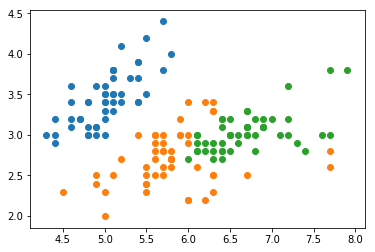

In [14]:
ll2, pis2, mus2, sigmas2 = new_em_gmm_orig(X, pis, mus, sigmas)